In [1]:
import json
import urllib
# from urlparse import urlparse
from urllib.parse import urlparse
import httplib2 as http #External library
import pandas as pd
from tqdm import tqdm
from onemapsg import OneMapClient
import time
import networkx as nx

In [2]:
#Authentication parameters
headers = { 'AccountKey' : 'esuwl3rGSEqFBc+rSpuWEg==',
            'accept' : 'application/json'} #this is by default

uri = 'http://datamall2.mytransport.sg' #Resource URL

bus_route_path = '/ltaodataservice/BusRoutes?$skip={}'
bus_route_out_file = "bus_routes{}.json"

bus_stops_path = '/ltaodataservice/BusStops?$skip={}'
bus_stop_out_file = "bus_stops{}.json"

In [42]:
def extract_data_datamall(headers,uri,path,save_path):
  data_list = []
  for lim in range(0, 25501, 500):
      #API parameters
      # print(lim)
      path = path.format(lim)
      #Build query string & specify type of API call
      target = urlparse(uri + path)
      method = 'GET'
      body = ''
      #Get handle to http
      h = http.Http()
      #Obtain results
      response, content = h.request(
      target.geturl(),
      method,
      body,
      headers)
      #Parse JSON to print
      jsonObj = json.loads(content)
      # print(json.dumps(jsonObj, sort_keys=True, indent=4))
      #Save result to file
      # with open(save_path.format(lim),"w") as outfile:
      # #Saving jsonObj["d"]
      #   json.dump(jsonObj, outfile, sort_keys=True, indent=4, ensure_ascii=False)
      data_list.extend(jsonObj['value'])
      # if(lim > 1000):
      #   break

  return data_list
  

## Bus stop info

In [43]:
bus_routes_all = extract_data_datamall(headers,uri,bus_route_path,bus_route_out_file)
bus_stop_info = extract_data_datamall(headers,uri,bus_stops_path,bus_stop_out_file)

In [39]:
len(bus_stop_info)

26000

In [7]:
def write_to_json(dict_obj,file_name):
    with open(file_name, "w") as outfile:
        json.dump(dict_obj, outfile)
    print('written file to '+file_name)

write_to_json(bus_routes_all,'bus_routes_all.json')
write_to_json(bus_stop_info,'bus_stop_info_all.json')

written file to bus_routes_all.json
written file to bus_stop_info_all.json


In [10]:
bus_stop_info_processed = {}

for deets in bus_stop_info:
  bus_stop_info_processed[deets['BusStopCode']] = deets
  bus_stop_info_processed[deets['BusStopCode']].pop('BusStopCode')

In [12]:
bus_stop_volume_aug = pd.read_csv('./transport_node_bus_202208.csv')
bus_stop_volume_aug['PT_CODE'] = bus_stop_volume_aug['PT_CODE'].astype(str)
bus_stop_volume_aug['PT_CODE'] = bus_stop_volume_aug['PT_CODE'].apply(lambda x: '0'+x if len(x) < 5 else x)
bus_stop_volume_aug.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2022-08,WEEKDAY,6,BUS,67551,2878,100
1,2022-08,WEEKENDS/HOLIDAY,6,BUS,67551,209,14
2,2022-08,WEEKENDS/HOLIDAY,7,BUS,66541,141,119
3,2022-08,WEEKDAY,7,BUS,66541,608,287
4,2022-08,WEEKENDS/HOLIDAY,17,BUS,54209,535,164


In [26]:
bus_stop_vol_aug = {}
for i in tqdm(range(len(bus_stop_volume_aug))):
  value = bus_stop_vol_aug.get(bus_stop_volume_aug.iloc[i]['PT_CODE'],False)

  if(value == False):
    bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']] = {'weekdays':{'tap_in':[0]*24,'tap_out':[0]*24},'weekends':{'tap_in':[0]*24,'tap_out':[0]*24}}

  if(bus_stop_volume_aug.iloc[i]['DAY_TYPE'] == 'WEEKDAY'):
    bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekdays']['tap_in'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_IN_VOLUME'])
    bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekdays']['tap_out'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_OUT_VOLUME'])
  else:
    bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekends']['tap_in'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_IN_VOLUME'])
    bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekends']['tap_out'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_OUT_VOLUME'])

100%|██████████| 195803/195803 [02:40<00:00, 1221.93it/s]


In [30]:
service_no_dict = {}

for deets in bus_routes_all:
  value = service_no_dict.get(deets['ServiceNo'],False)

  if(value == False):
    service_no_dict[deets['ServiceNo']] = {'busstop':[],'intial_dist':[],'busstop_info':{}}

  service_no_dict[deets['ServiceNo']]['busstop'].append(deets['BusStopCode'])
  service_no_dict[deets['ServiceNo']]['intial_dist'].append(str(deets['Distance']))

  busstop_info = bus_stop_info_processed.get(deets['BusStopCode'],{})
  service_no_dict[deets['ServiceNo']]['busstop_info'][deets['BusStopCode']] = busstop_info
  service_no_dict[deets['ServiceNo']]['busstop_info'][deets['BusStopCode']].update(bus_stop_vol_aug[deets['BusStopCode']])

In [31]:
bus_stop_full_info = {}
for keys in service_no_dict.keys():
    bus_stop_full_info.update(service_no_dict[keys]['busstop_info'])

In [32]:
write_to_json(service_no_dict,'new_service_no_dict.json')

written file to new_service_no_dict.json


In [35]:
(service_no_dict.keys())

dict_keys(['10', '100', '100A', '101', '102', '103', '105'])

## Train stations info

In [17]:
train_station = pd.read_csv('./Train Station Codes and Chinese Names.csv')
train_station.head()

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North-South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North-South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线
4,NS5,Yew Tee,油池,North-South Line,南北线


In [166]:
train_station_names = {}

for i in range(len(train_station)):
    try:
        train_station_names[train_station.iloc[i]['mrt_station_english']] = train_station_names[train_station.iloc[i]['mrt_station_english']] + '-' + train_station.iloc[i]['stn_code']
    except:
        train_station_names[train_station.iloc[i]['mrt_station_english']] = train_station.iloc[i]['stn_code']

In [168]:
new_stn_code = []
for i in range(len(train_station)):
    new_stn_code.append(train_station_names[train_station.iloc[i]['mrt_station_english']])

train_station['new_stn_code'] = new_stn_code

In [170]:
train_station_dict = {}

for i in range(len(train_station)):
  value = train_station_dict.get(train_station.iloc[i]['mrt_line_english'],False)
  if(value == False):
    train_station_dict[train_station.iloc[i]['mrt_line_english']] = {'stn_code':[],'stn_info':{}}

  train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_code'].append(train_station.iloc[i]['new_stn_code'])
  # train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info']['stn_name'] = train_station.iloc[i]['mrt_station_english']

  Client = OneMapClient("vaidyanathanabhishek@gmail.com", "ShakeShake033@")
  data_dict = Client.search("EW27")['results'][0]

  # time.sleep(5)
  
  train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info'][train_station.iloc[i]['new_stn_code']] = {'stn_name':train_station.iloc[i]['mrt_station_english']}
  train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info'][train_station.iloc[i]['new_stn_code']].update(data_dict)

In [192]:
train_station_full_info = {}

for keys in train_station_dict:
    train_station_full_info.update(train_station_dict[keys]['stn_info'])

## Save to json files

In [195]:
def write_to_json(dict_obj,file_name):
    with open(file_name, "w") as outfile:
        json.dump(dict_obj, outfile)
    print('written file to '+file_name)

write_to_json(service_no_dict,'service_no_dict.json')
write_to_json(bus_stop_full_info,'bus_stop_full_info.json')
write_to_json(train_station_dict,'train_station_dict.json')
write_to_json(train_station_full_info,'train_station_full_info.json')

## NetworkX - Graph

In [148]:
bus_stop_nodes = list(bus_stop_vol_aug.keys())

In [157]:
bus_routes_graph = nx.DiGraph()
for key in service_no_dict.keys():
    i = 0
    while i < (len(service_no_dict[key]['busstop'])-1):
        first_node = service_no_dict[key]['busstop'][i]
        second_node = service_no_dict[key]['busstop'][i+1]
        bus_routes_graph.add_edge(first_node,second_node)

        i = i+1

edge_labels = dict([((n1, n2), {'labels':'bus_route'})
                    for n1, n2 in bus_routes_graph.edges])
nx.set_edge_attributes(bus_routes_graph, edge_labels)

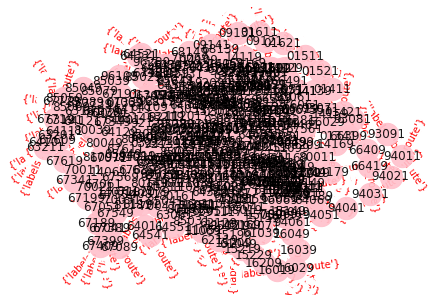

In [161]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spring_layout(bus_routes_graph)
plt.figure()
nx.draw(
    bus_routes_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in bus_routes_graph.nodes()}
)
nx.draw_networkx_edge_labels(
    bus_routes_graph, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.axis('off')
plt.show()

In [174]:
train_routes_graph = nx.DiGraph()
for key in train_station_dict.keys():
    i = 0
    while i < (len(train_station_dict[key]['stn_code'])-1):
        first_node = train_station_dict[key]['stn_code'][i]
        second_node = train_station_dict[key]['stn_code'][i+1]
        train_routes_graph.add_edge(first_node,second_node)

        i = i+1

edge_labels = dict([((n1, n2), {'labels':'train_route'})
                    for n1, n2 in train_routes_graph.edges])
nx.set_edge_attributes(train_routes_graph, edge_labels)

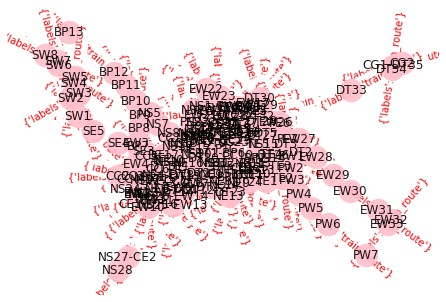

In [175]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spring_layout(train_routes_graph)
plt.figure()
nx.draw(
    train_routes_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in train_routes_graph.nodes()}
)
nx.draw_networkx_edge_labels(
    train_routes_graph, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.axis('off')
plt.show()